<a href="https://colab.research.google.com/github/adalbertii/Modele-regresyjne/blob/main/mpg-case-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wykorzystanie danych  [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg).

[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


Demonstracja sposobu budowania modelu przeznaczonego do predykcji efektywnosci spalania paliwa

In [2]:
!pip install -q seaborn

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


np.set_printoptions(precision=3, suppress=True)

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.13.0


### Pobranie danych do uczenia modelu
Wykorzystanie modułu pandas


In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Liczba cylindrow', 'Pojemność skokowa', 'Moc', 'Waga',
                'Przyspieszenie', 'Rok modelu', 'Pochodzenie']
# mpg - miles per gallon
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [6]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Liczba cylindrow,Pojemność skokowa,Moc,Waga,Przyspieszenie,Rok modelu,Pochodzenie
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Wstępne przygotowanie danych




In [7]:
dataset.isna().sum()

MPG                  0
Liczba cylindrow     0
Pojemność skokowa    0
Moc                  6
Waga                 0
Przyspieszenie       0
Rok modelu           0
Pochodzenie          0
dtype: int64

Istnieją braki danych
Dla uproszczenia - usuwamy rekordy zawierajace braki danych

In [8]:
dataset = dataset.dropna()

Kolumna 'Pochodzenie` jet atrybutem kategorycznym, nie numerycznym .
Nalezy zatem przeprowadić na tej kolumnie transfomację "one-hot-encod"
W tymn celu wykorzystana zostanie  metoda [pd.get_dummies]

In [9]:
dataset['Pochodzenie'] = dataset['Pochodzenie'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [10]:
dataset = pd.get_dummies(dataset, columns=['Pochodzenie'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Liczba cylindrow,Pojemność skokowa,Moc,Waga,Przyspieszenie,Rok modelu,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Podział danych na dane treningowe i testowe

Dane testowe zostaną wykorzystane do końcowej ewaluacji modelu

In [11]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [12]:
train_dataset.shape

(314, 10)

In [13]:
train_dataset.index

Int64Index([146, 282,  69, 378, 331, 257, 310, 328, 125, 108,
            ...
            171,  70, 307,  49, 209, 281, 229, 150, 145, 182],
           dtype='int64', length=314)

### Wstępna analiza danych



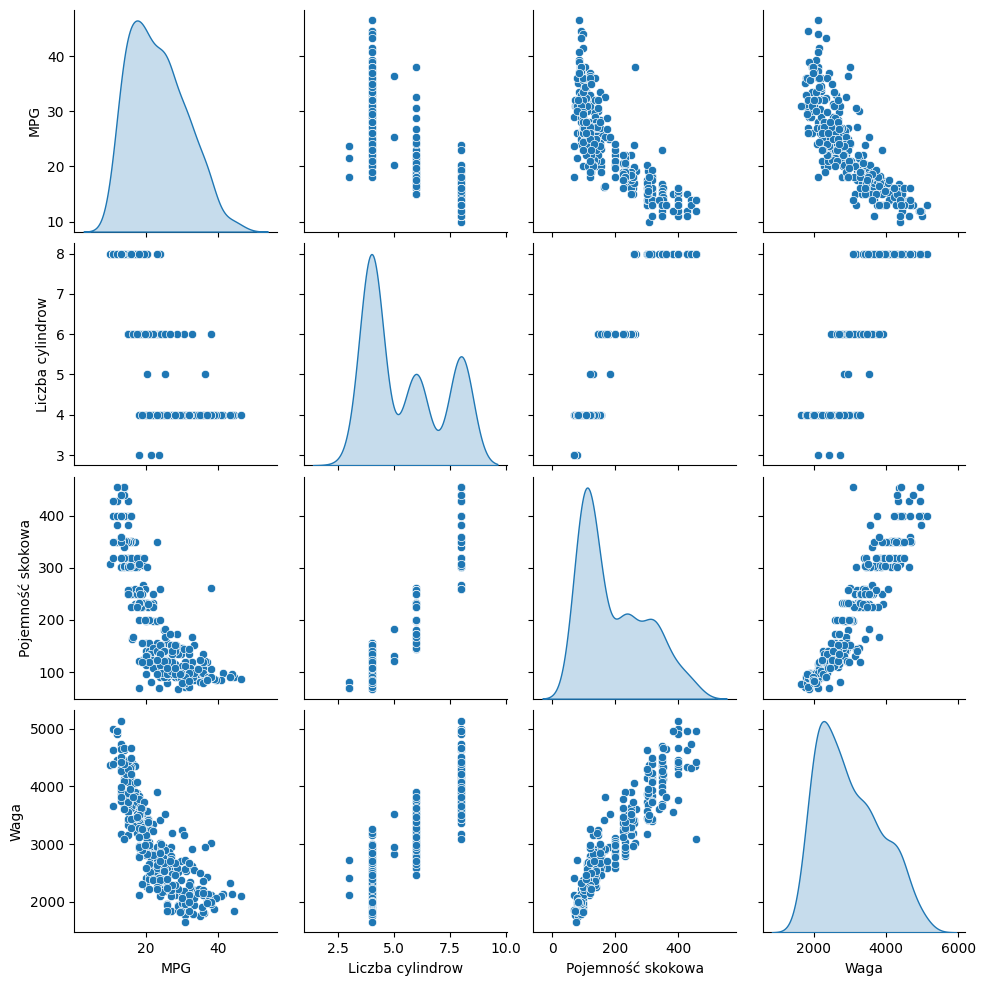

In [14]:
sns.pairplot(train_dataset[['MPG', 'Liczba cylindrow', 'Pojemność skokowa', 'Waga']], diag_kind='kde')

Weryfikacja rozładów statystycznych zmiennych objaśniajacych

In [15]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Liczba cylindrow,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Pojemność skokowa,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Moc,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Waga,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Przyspieszenie,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Rok modelu,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Rozdzielenie zmiennych objaśniajacych od zmiennej objaśnianej (etykiety)


In [16]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [17]:
train_features

,Liczba cylindrow,Pojemność skokowa,Moc,Waga,Przyspieszenie,Rok modelu,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [18]:
train_labels

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

## Normalizacja danych

Wartość średnia i odchylenie standardowe jest mocno żróżnicowane  

In [19]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Liczba cylindrow,5.477707,1.699788
Pojemność skokowa,195.318471,104.331589
Moc,104.869427,38.096214
Waga,2990.251592,843.898596
Przyspieszenie,15.559236,2.789230
Rok modelu,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


Dobrą praktyką jest normalizacja cech, które używają różnych skal i zakresów.

Jednym z powodów, dla których jest to ważne, jest to, że cechy są mnożone przez wagi modelu. Tak więc skala wyników i skala gradientów zależy od skali danych wejściowych.

Chociaż model *może* uczyć  się bez normalizacji cech, normalizacja sprawia, że szkolenie jest znacznie bardziej stabilne.


### Warstwa normalizująca  dane

Tworzymy instancję normalizatora

In [20]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Dokonujemy normalizacji zmiennych objaśniajacych :

In [21]:
normalizer.adapt(np.array(train_features))

Gdy warstwa jest wywoływana, zwraca dane wejściowe, z każdą cechą niezależnie znormalizowaną:

In [22]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Regresja liniowa

Przed zbudowaniem głebokiej sieci neuronowej przeanalizujemu budowę liniowej sieci z jedną i wieloma cechami (zmiennymi objaśniajacymi)

### Regresja lionowa z jedną zmienną objaśniajacą

Predykcja 'MPG' na podstwie zmiennej 'Moc'.

Sieć neuronowa będzie zbudowana z dwóch warstw:

- warstwy normalizującej atrybut wejściowy 'moc` (przy użyciu klasy  `tf.keras.layers.Normalization).
- warstwy Dense

In [23]:
horsepower = np.array(train_features['Moc'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [24]:
horsepower_normalizer

Budowa modelu Keras

In [25]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


Po zbudowaniu modelu należy go skompilować.

Na tym etapie kluczowy jest dobór hiperparametrów modelu:
*   'loss'
*   'optimizer'



In [27]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Proces uczenia modelu

In [ ]:
%%time
history = horsepower_model.fit(
    train_features['Moc'],
    train_labels,
    epochs=100,
    verbose=1,
    validation_split = 0.2) #Oblicza wyniki walidacji na 20% danych treningowych

Wizualizacja procesu uczenia przy użyciu statystyk zapisanych w obiekcie `history`.

In [29]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.807216,4.199985,95
96,3.803669,4.171388,96
97,3.805483,4.171243,97
98,3.803044,4.184310,98
99,3.802344,4.203977,99


In [30]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

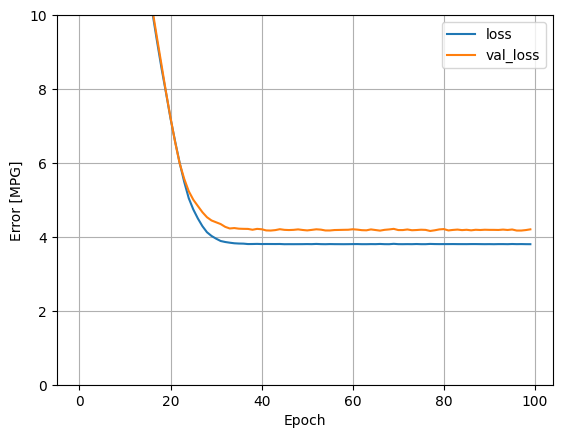

In [31]:
plot_loss(history)

Zachowanie rezultatów na poźniejsze porównania

In [32]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Moc'],
    test_labels, verbose=0)

Ponieważ jest to regresja pojedynczej zmiennej, łatwo jest wyświetlić prognozy modelu jako funkcję danych wejściowych.

In [33]:
x = tf.linspace(0.0, 250, 251)


In [34]:
x[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32)>

In [35]:
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


In [38]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Moc'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

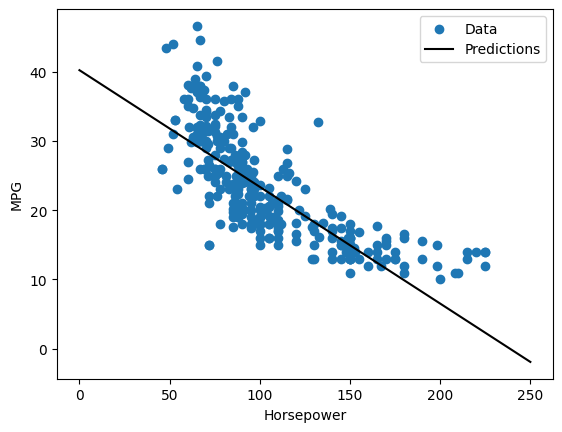

In [39]:
plot_horsepower(x, y)

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $x$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each example:

In [ ]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 54ms/step


array([[ 0.   ],
       [ 0.36 ],
       [-0.768],
       [ 1.233],
       [-0.267],
       [-0.188],
       [-0.373],
       [ 0.572],
       [-0.696],
       [-1.426]], dtype=float32)

When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of `(9, 1)`:

In [ ]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.233],
       [-0.004],
       [ 0.431],
       [-0.342],
       [-0.344],
       [ 0.639],
       [ 0.148],
       [-0.547],
       [-0.287]], dtype=float32)>

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs:

In [ ]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 5.36 s, sys: 178 ms, total: 5.53 s
Wall time: 10.7 s


Using all the inputs in this regression model achieves a much lower training and validation error than the `horsepower_model`, which had one input:

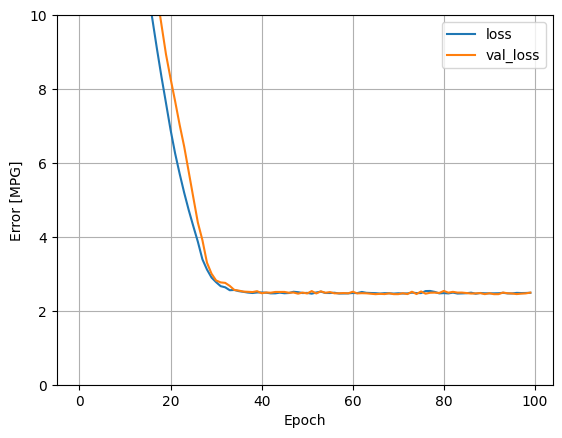

In [ ]:
plot_loss(history)

Collect the results on the test set for later:

In [ ]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=1)

3/3 [==============================] - 0s 6ms/step - loss: 2.4819


In [ ]:
test_results

{'horsepower_model': 3.64575457572937, 'linear_model': 2.481851577758789}

## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `horsepower_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure, so the `compile` method is included in the `build_and_compile_model` function below.

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and a single input

Create a DNN model with only `'Horsepower'` as input and `horsepower_normalizer` (defined earlier) as the normalization layer:

In [ ]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

This model has quite a few more trainable parameters than the linear models:

In [ ]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4356 (17.02 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


Train the model with Keras `Model.fit`:

In [ ]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
8/8 [==============================] - 0s 48ms/step - loss: 3.2513 - val_loss: 3.7763
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 3.2492 - val_loss: 3.7676
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 3.2528 - val_loss: 3.7879
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 3.2482 - val_loss: 3.7791
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 3.2522 - val_loss: 3.7751
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 3.2470 - val_loss: 3.7664
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 3.2530 - val_loss: 3.7703
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 3.2467 - val_loss: 3.7835
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 3.2503 - val_loss: 3.7690
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 3.2469 - val_loss: 3.7900
Epoch 11/100
8/8 [==========

This model does slightly better than the linear single-input `horsepower_model`:

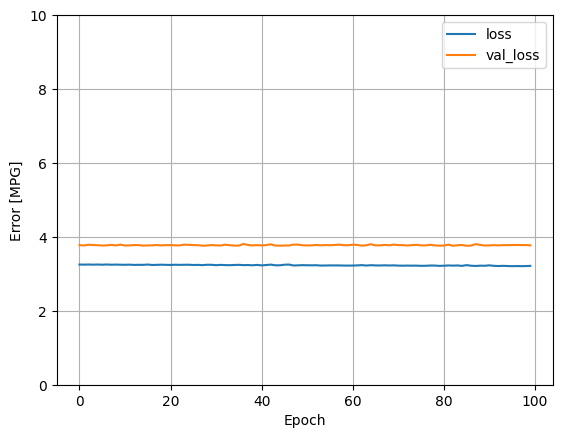

In [ ]:
plot_loss(history)

If you plot the predictions as a function of `'Horsepower'`, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


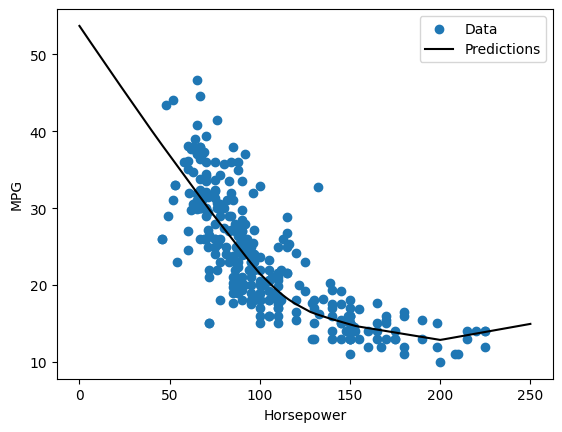

In [ ]:
plot_horsepower(x, y)

Collect the results on the test set for later:

In [ ]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 9)                 19        
 on)                                                             
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4884 (19.08 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 5.19 s, sys: 185 ms, total: 5.38 s
Wall time: 5.89 s


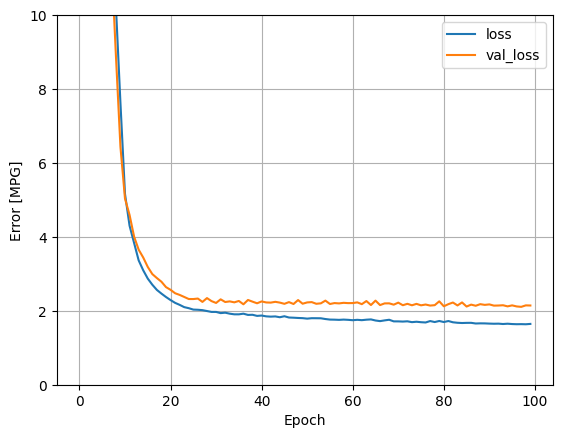

In [ ]:
plot_loss(history)

Collect the results on the test set:

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Since all models have been trained, you can review their test set performance:

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.645755
linear_model,2.481852
dnn_horsepower_model,2.840298
dnn_model,1.628844


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

3/3 [==============================] - 0s 4ms/step


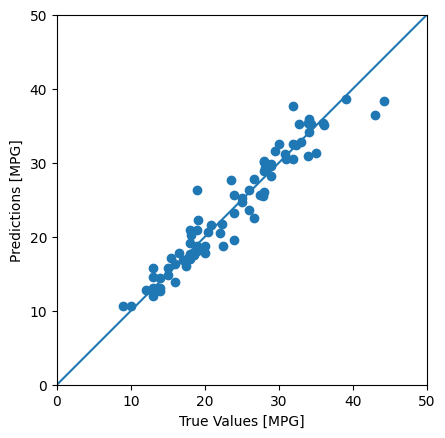

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

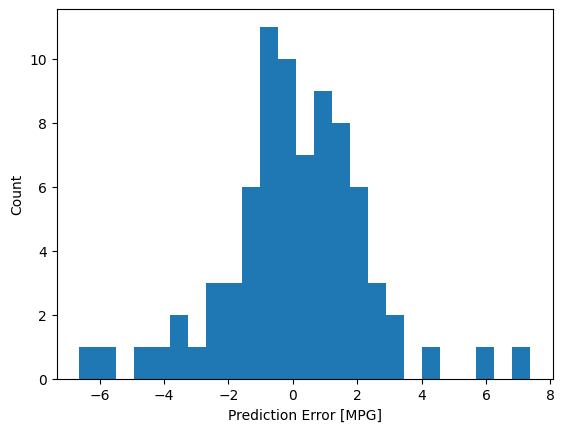

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

If you reload the model, it gives identical output:

## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.